In [ ]:
%pylab inline

### Create data
1. Create $k$ random points in $[0,1]^2$
2. Choose a pair of points and add 1-3 points random convex combinations.
3. Repeat 2 $m$ times

In [ ]:
def makeData(k=10,l=10,m=3):
    """ Create data 
    k: Number of points (+1 for same x)
    l: Number of lines to create.
    m: Number of points added along each line
    """

    D=random.rand(2,k) #create k random points in [0,1]^2
    new=copy(D[:,0:1]) # create a point that has the same x value as D[:,0]
    new[1,0] +=2.
    D=append(D,new,axis=1)

    plot(D[0,:],D[1,:],'o');

    for i in range(l):
        if i==0:
            i1,i2=0,k
        else:
            i1,i2=random.choice(k,2,replace=False)
        #print(i1,i2)
        P1=D[:,i1:i1+1]; P2=D[:,i2:i2+1]
        for j in range(m):
            alpha=random.rand()*2.-1. # choose a random number between 0 an 1
            new=(P1+P2)/2.+alpha*(P1-P2)
            D=append(D,new,axis=1)
    plot(D[0,:],D[1,:],'.');
    return D
D=makeData()

In [ ]:
with open('pair.csv','w') as file:
    for i in range(D.shape[1]):
        file.write(str(i)+','+','.join(['%6.5f'%a for a in D[:,i]])+'\n')

In [ ]:
!cat pair.csv

### We compute the line parameters for each pair of points.
Suppose the points are $(x_1,y_1)$ and $(x_2,y_2)$.

* If $x_1=x_2$ this is a vertical line which we represent by $(x_1,nan)$
* If $x_1 \neq x_2$ then we use $(a,b)$ such that $ax_1+b=y_1$ and $a x_2 +b=y_2$. The solution to which is is $a=\frac{y_1-y_2}{x_1-x_2}$, $b=y_1-a x_1$

In [ ]:
Pairs=[]
n=D.shape[1]
for i in range(n):
    for j in range(i+1,n):
        Pairs.append(((i,j),tag(D[:,i],D[:,j])))

sorted(Pairs,key=lambda x:x[1])[:5]

## Homework starts here

In [1]:
#start the SparkContext
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(master="local[4]")

In [10]:
%pylab inline
#find colinearity
def tag(D1,D2):
    accuracy=100000.
    def R(x):
        return int(x*accuracy)/accuracy

    if D1[0]==D2[0]:  # vertical pair
        return (R(D1[0]),)
    else:
        a=(D1[1]-D2[1])/(D1[0]-D2[0])
        b=D1[1]-a*D1[0]
        return (R(a),R(b))

Populating the interactive namespace from numpy and matplotlib


In [22]:
def _parse(line):
    print(line)
    i,x,y=line.split(',')
    print(i,x,y)
    return (int(i),array([float(x),float(y)]))
A=sc.textFile('pair.csv').map(_parse)
Data=A.collect()
D=stack([e[1] for e in Data]).transpose()
D

array([[ 0.84184,  0.51706,  0.59582,  0.01834,  0.14702,  0.2151 ,
         0.06942,  0.83893,  0.34951,  0.61493,  0.84184,  0.84184,
         0.84184,  0.84184, -0.05143,  0.17133,  0.35284,  0.03523,
         0.30268, -0.0391 ,  0.33707,  0.39554,  1.0177 ,  0.46878,
         0.4459 ,  0.43612,  0.79172,  0.3703 ,  0.17938,  0.84285,
         0.20046, -0.09739,  0.75732,  0.71945,  0.86425,  0.63405,
         1.03965,  0.67218,  1.0334 ,  0.24086,  0.9913 ],
       [ 0.14094,  0.31061,  0.46705,  0.92761,  0.98446,  0.39748,
         0.91819,  0.9186 ,  0.38945,  0.47249,  2.14094,  1.72425,
         1.61211, -0.56062,  1.21325,  0.95644,  0.74717,  0.88212,
         0.16152,  1.08239,  0.376  ,  0.43921,  1.11188,  0.33333,
         0.34409,  0.3487 ,  0.24121,  0.72705,  0.94715,  0.25534,
         0.80589,  1.06115,  0.75607,  0.68065,  0.96902,  0.35003,
        -0.05811,  0.31166, -0.09162,  0.87054, -0.04051]])

In [12]:
B=A.cartesian(A)
B.count()

1681

In [13]:
C=B.filter(lambda X:X[0][0]<X[1][0])
C.count()

820

In [14]:
E=C.map(lambda X:(tag(X[0][1],X[1][1]),((X[0][0],X[1][0]),)))
E.take(2)

[((-0.52241, 0.58072), ((0, 1),)), ((-1.32554, 1.25683), ((0, 2),))]

In [15]:
F=E.reduceByKey(lambda a,b:a+b).filter(lambda X:len(X[1])>1)
F.take(1)

[((-2.69433, 0.97704), ((17, 18), (17, 19), (18, 19)))]

In [16]:
def conc(pairs):
    A=set()
    for p in pairs:
        for e in p:
            A.add(e)
    return A
Final=F.mapValues(conc).collect()

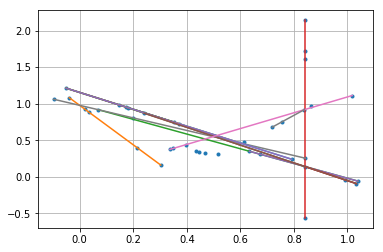

In [23]:
plot(D[0,:],D[1,:],'.');
for P,S in Final:
    A=D[:,list(S)]
    i1 = argmin(A[1,:])
    i2 = argmax(A[1,:])
    plot((A[0,i1],A[0,i2]),(A[1,i1],A[1,i2]))
    grid()
